In [1]:
### run this if using google colab to mount google drive as local storage

from google.colab import drive
import os
drive.mount('/content/gdrive')

repo_path = '/content/gdrive/My Drive/colab/NLP-Bootcamp/'

ModuleNotFoundError: No module named 'google'

In [2]:
import pandas as pd
import collections
%matplotlib inline

# Import modules to calculate accuracy and confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score

## 2. Loading Data ##

In [3]:
### run below 2 lines of code for setting train & test data path on google colab
'''
trainData = os.path.join(repo_path, 'data/sentiment140_160k_tweets_train.csv')
testData = os.path.join(repo_path, 'data/sentiment140_test.csv')
'''

### run below 3 lines of code for setting train & test data path on local machine
DATA = './data/'
trainData = DATA + 'sentiment140_160k_tweets_train.csv'
testData =  DATA + 'sentiment140_test.csv'

train = pd.read_csv(trainData)
test = pd.read_csv(testData)

train.head()

,target,ids,user,text
0,p,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ..."
1,p,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...
2,p,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...
3,p,1753662211,lovemandy,"had a good day driving up mountains, visiting ..."
4,p,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.


Looking at distribution of *'positives'* & *'negatives'* samples in train dataset 

In [4]:
collections.Counter(train['target'])

Counter({'p': 80000, 'n': 79985})

<AxesSubplot:xlabel='target'>

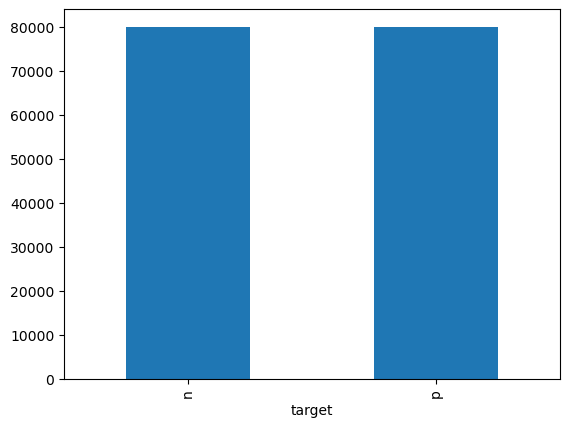

In [5]:
train.groupby('target').size().plot(kind='bar')

We will find that it is a relatively well-balanced dataset

## 3. Data (Text) Preprocessing ##

In [6]:
### mapping a dictionary of apostrophe words

appos = {
"aren't" : "are not",
"can't" : "cannot",
"cant" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"im" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"gg" : "going"
}

In [7]:
import re

def preprocess_text(sentence):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','', sentence['text'])
    text = re.sub('@[^\s]+','', text)
    text = text.lower().split()
    reformed = [appos[word] if word in appos else word for word in text]
    reformed = " ".join(reformed) 
    text = re.sub('&[^\s]+;', '', reformed)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    #text = re.sub(' [\w] ', ' ', text)
    return text.strip()

preprocess = train
preprocess['ugc'] = preprocess.apply(preprocess_text, axis=1)

preprocess.head()

,target,ids,user,text,ugc
0,p,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ...",anyway and now abby and i share all our crops ...
1,p,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...,few times I am trying to leave comments in you...
2,p,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...,good morning angie I will be in the atl july 8...
3,p,1753662211,lovemandy,"had a good day driving up mountains, visiting ...",had a good day driving up mountains visiting k...
4,p,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.,downloading some songs i love lady gaga


## 4. Sentiment Analysis using Lexicon-based Method

There are two types of lexicon-based sentiment analyzing approcaches - _Polarity_ and _Valence_ based.

_VADER_ is a _VALENCE_ based sentiment analyzer.

*Valence*-based approach taken into consideration the "intensity" of a word as opposed to only the polarity (+ve or -ve). For example, "Great" is treated as more +ve as opposed to "Good".

References:
http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

Scale for the classification model used base on compound value:

1. Positive = >=0
2. Negative = <0


In [8]:
!pip install vaderSentiment

     ------------------------------------ 126.0/126.0 kB 337.3 kB/s eta 0:00:00


In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [10]:
def print_sentiment_scores(ugc):
    snt = analyzer.polarity_scores(ugc['ugc'])  # Calling the polarity analyzer
    return snt['compound']

In [11]:
compound = train
compound['VADER']=compound.apply(print_sentiment_scores, axis=1)

compound.head()

,target,ids,user,text,ugc,VADER
0,p,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ...",anyway and now abby and i share all our crops ...,0.6361
1,p,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...,few times I am trying to leave comments in you...,-0.0258
2,p,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...,good morning angie I will be in the atl july 8...,0.4404
3,p,1753662211,lovemandy,"had a good day driving up mountains, visiting ...",had a good day driving up mountains visiting k...,0.7717
4,p,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.,downloading some songs i love lady gaga,0.6369


In [12]:
confusion_matrix(compound['target'], compound['predict'])
accuracy_score(compound['target'], compound['predict'])

KeyError: 'predict'

In [ ]:
def custom_predict(ugc):
    snt = analyzer.polarity_scores(ugc['ugc'])  # Calling the polarity analyzer
    if snt['neg'] > snt['pos']:
        return 'n'
    elif snt['pos'] > snt['neg']:
        return 'p'
    else:
        return 'p'

vader = train
vader['predict']=vader.apply(custom_predict, axis=1)

In [ ]:
confusion_matrix(vader['target'], vader['predict'])
accuracy_score(vader['target'], vader['predict'])

## 5. Sentiment Analysis using Machine Learning-based Method: Naive Bayes

In [ ]:
#Import feature engineering modules and test_train_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

#Import classification algorithm
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

#Import modules to calculate accuracy and confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

Naive Bayes with TF-IDF on original text data

In [ ]:
tv = TfidfVectorizer(ngram_range=(1,3),max_features=20000,stop_words='english') 
X = tv.fit_transform(train['text'])

Xtrain, Xtest, ytrain, ytest = train_test_split(X, train['target'],
                                               test_size = 0.2, shuffle=True)

nb = MultinomialNB(alpha=6.5, fit_prior=False)
nb.fit(Xtrain,ytrain)
pred = nb.predict(Xtest)

print(accuracy_score(ytest,pred))
print(confusion_matrix(ytest,pred))
print(classification_report(ytest,pred))

Naive Bayes with TF-IDF on pre-processed text data - achieved very minimal accuracy improvement

In [ ]:
tv = TfidfVectorizer(ngram_range=(1,3),max_features=20000,stop_words='english') 
X = tv.fit_transform(preprocess['ugc'])

Xtrain, Xtest, ytrain, ytest = train_test_split(X, preprocess['target'],
                                               test_size = 0.2, shuffle=True)

nb = MultinomialNB(alpha=6.5, fit_prior=False)
nb.fit(Xtrain,ytrain)
pred = nb.predict(Xtest)

print(accuracy_score(ytest,pred))
print(confusion_matrix(ytest,pred))
print(classification_report(ytest,pred))

Naive Bayes with Grid Search Hyperparameter Tuning & 10-Fold Cross Validation - achieving higher accuracy over the mdoel without hyperparameter tuning 

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train['text'], train['target'],
                                               test_size = 0.2, shuffle=True)

In [ ]:
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=10)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))
print(accuracy_score(y_test, clf.predict(x_test)))
print(confusion_matrix(y_test, clf.predict(x_test)))

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(preprocess['ugc'], preprocess['target'],
                                               test_size = 0.2, shuffle=True)

In [ ]:
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=10)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))
print(accuracy_score(y_test, clf.predict(x_test)))
print(confusion_matrix(y_test, clf.predict(x_test)))

In [ ]:
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

In [ ]:
from google.colab import files ### remove this line of code if not using colab

test['ugc'] = test.apply(preprocess_text, axis=1)
y_kaggle = clf.predict((test['ugc']))
test['target'] = pd.DataFrame(y_kaggle.tolist())
test[['target', 'ids']].to_csv("nb_submission.csv", index=False)

files.download('nb_submission.csv') ### remove this line of code if not using colab


In [ ]:
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=10)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))
print(accuracy_score(y_test, clf.predict(x_test)))
print(confusion_matrix(y_test, clf.predict(x_test)))

## 6. Sentiment Analysis using Machine Learning-based Method: Linear SVM ##
with Grid Search Hyperparameter Tuning & 10-Fold Cross Validation

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC())])
tuned_parameters = {
    'vect__ngram_range': [(1, 2), (1, 3), (1, 4)],
    'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__tol': [1, 1e-1, 1e-2, 1e-3]
}

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(preprocess['ugc'], preprocess['target'],
                                               test_size = 0.2, shuffle=True)

In [ ]:
clf = GridSearchCV(text_clf, tuned_parameters, cv=10)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))
print(accuracy_score(y_test, clf.predict(x_test)))
print(confusion_matrix(y_test, clf.predict(x_test)))

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

In [ ]:
from google.colab import files ### remove this line of code if not using colab

test['ugc'] = test.apply(preprocess_text, axis=1)
y_kaggle = clf.predict((test['ugc']))
test['target'] = pd.DataFrame(y_kaggle.tolist())
test[['target', 'ids']].to_csv("l_svm_submission.csv", index=False)

files.download('l_svm_submission.csv') ### remove this line of code if not using colab

## 7. Sentiment Analysis using Machine Learning-based Method: XGBoost

In [ ]:
!pip install xgboost

In [ ]:
tv = TfidfVectorizer(ngram_range=(1,2), max_features=20000, stop_words='english', min_df=.0025, max_df=0.25) 
X = tv.fit_transform(preprocess['ugc'])

x_train, x_test, y_train, y_test = train_test_split(X, preprocess['target'],
                                               test_size = 0.2, shuffle=True)

In [ ]:
xgb = XGBClassifier(max_depth=10, n_estimators=400, learning_rate=0.3, objective='binary:logistic')
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)

In [ ]:
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

## 8. Sentiment Analysis using Machine Learning-based Method: Decision Tree

In [ ]:
tv = TfidfVectorizer(ngram_range=(1,2), max_features=20000, stop_words='english') 
X = tv.fit_transform(preprocess['ugc'])

x_train, x_test, y_train, y_test = train_test_split(X, preprocess['target'],
                                               test_size = 0.2, shuffle=True)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(Xtrain,ytrain)
pred = dt.predict(Xtest)

In [ ]:
print(accuracy_score(ytest,pred))
print(confusion_matrix(ytest,pred))
print(classification_report(ytest,pred))

## 9. Sentiment Analysis using Machine Learning-based Method: Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(Xtrain,ytrain)
pred = rf.predict(Xtest)

In [ ]:
print(accuracy_score(ytest,pred))
print(confusion_matrix(ytest,pred))
print(classification_report(ytest,pred))

## 10. Sentiment Analysis using Machine Learning-based Method: Extra Trees

In [ ]:
etc=ExtraTreesClassifier()
etc.fit(Xtrain,ytrain)
pred=etc.predict(Xtest)

In [ ]:
print(accuracy_score(ytest,pred))
print(confusion_matrix(ytest,pred))
print(classification_report(ytest,pred))

## 11. Sentiment Analysis using Machine Learning-based Method: SVC ##

_Warning - approximately 3hrs of processing_ 

In [ ]:
#Import feature engineering modules and test_train_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

tv = TfidfVectorizer(ngram_range=(1,3)) 
X = tv.fit_transform(preprocess['ugc'])

Xtrain, Xtest, ytrain, ytest = train_test_split(X, preprocess['target'],
                                               test_size = 0.2, shuffle=True)

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(Xtrain,ytrain)
pred = svm.predict(Xtest)

print(accuracy_score(ytest,pred))
print(confusion_matrix(ytest,pred))
print(classification_report(ytest,pred))

In [ ]:
# Uncomment and run below line of code if using google colab
# from google.colab import files

test['ugc'] = test.apply(preprocess_text, axis=1)
y_kaggle = svm.predict(tv.transform(test['ugc']))
test['target'] = pd.DataFrame(y_kaggle.tolist())
test[['target', 'ids']].to_csv("svc_submission.csv", index=False)

# Uncommon and run below line of code if using google colab 
# files.download('svc_submission.csv')

## Further - Text Preprocessing: Porter Stemmer ##

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

#nltk.download('punkt') 

#create an object of class PorterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()


In [ ]:
def stemSentence(sentence):
    token_words = word_tokenize(sentence['ugc'])
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)
  
preprocess['stem'] = preprocess.apply(stemSentence, axis=1)
preprocess.head()

## Sentiment Analysis using Support Vector Machine, SVM with GridSearch (Machine Learning-Based)

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np
# specify parameters to search & test for
parameters = {'fit_prior':(True, False), 'alpha': np.linspace(0.5, 15.5)}

In [ ]:
nb=MultinomialNB()
clf = GridSearchCV(nb, parameters, cv=5)
clf.fit(Xtrain,ytrain)     

In [ ]:
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

In [ ]:
l_svm = LinearSVC()
l_svm.fit(Xtrain,ytrain)
pred=l_svm.predict(Xtest)

print(accuracy_score(ytest,pred))
print(confusion_matrix(ytest,pred))
print(classification_report(ytest,pred))

In [ ]:
parameters = {'C': np.linspace(1, 10), 'fit_intercept':(True, False)}

In [0]:
l_svm = LinearSVC()
clf = GridSearchCV(l_svm, parameters, cv=5)
clf.fit(Xtrain,ytrain)

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.7472731818607995
Best Params:  {'C': 1.0, 'fit_intercept': True}
